In [2]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
%matplotlib inline
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
from torch.optim.lr_scheduler import StepLR
#from dog-breed-classifier-final.ipynb piazza lindell @60

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!find /content/DBIsubset -type f | wc -l



647


In [4]:
!ls /content/DBIsubset/

bernese_mountain_dog  chihuahua		labrador_retriever  siberian_husky
border_collie	      golden_retriever	pug
/bin/bash: line 1: nvdia-smi: command not found


In [5]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomCrop(112),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
!unzip -q -o "/content/drive/MyDrive/DBIsubset.zip" -d "/content/"
# !unzip -q -o "/content/drive/MyDrive/DBIsubset.zip" -d "/content/" "*.jpg"
# !unzip -q -o "/content/drive/MyDrive/DBIsubset.zip" -d "/content/" "*.jpg" "*.png"
!find /content/ -name "__MACOSX" -exec rm -rf {} +
# !find /content/ -type d -name "__MACOSX" -prune -exec rm -rf {} +

!find /content/ -name "._*" -exec rm -rf {} +
!find /content/ -name ".DS_Store" -exec rm -rf {} +
!find /content/ -name ".*" -exec rm -rf {} +
!ls /content/DBIsubset
dataset_path = '/content/DBIsubset'
dataset = ImageFolder(root=dataset_path, transform=transform)

rm: cannot remove '/content/drive/.shortcut-targets-by-id': Operation canceled
rm: cannot remove '/content/drive/.file-revisions-by-id': Operation canceled
rm: cannot remove '/content/drive/.Trash-0': Directory not empty
rm: cannot remove '/content/drive/.Encrypted/MyDrive': Operation canceled
rm: cannot remove '/content/drive/.Encrypted/.shortcut-targets-by-id': Operation canceled
rm: cannot remove '/content/drive/.Encrypted/.shortcut-targets-by-id': Operation canceled
bernese_mountain_dog  chihuahua		labrador_retriever  siberian_husky
border_collie	      golden_retriever	pug


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
num_classes = len(dataset.classes)
rsNet_model = resnet18(pretrained= False)
#layer match with classess

In [13]:
def trainRsnet(model, train_loader, val_loader, test_loader, epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    train_accuracy, val_accuracy, test_accuracy = [], [], []

    for epoch in range(epochs):
      #training now
      model.train()
      trained = 0
      total = 0
      for img, labels in train_loader:
        img, labels = img.to(device), labels.to(device)
        ret = model(img)

        loss = criterion(ret, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds= torch.max(ret,1)
        total += labels.size(0)
        trained += torch.sum(preds == labels).item()

      train_acc = 100 * trained / total
      train_accuracy.append(train_acc)

      #Validate now
      model.eval()
      validated = 0
      total = 0
      with torch.no_grad():
        for img, labels in val_loader:
          img, labels = img.to(device), labels.to(device)
          ret = model(img)
          _, preds = torch.max(ret, 1)
          total+= labels.size(0)
          validated += torch.sum(preds == labels).item()

      val_acc = 100 * validated / total
      val_accuracy.append(val_acc)

      #testing now
      passed = 0
      tot = 0
      with torch.no_grad():
        for img, labels in test_loader:
          img, labels = img.to(device), labels.to(device)
          ret = model(img)
          _, preds = torch.max(ret,1)
          tot += labels.size(0)
          passed += torch.sum(preds == labels).item()
      test_acc = 100 * passed / tot
      test_accuracy.append(test_acc)



      scheduler.step()
    return train_accuracy, val_accuracy, test_accuracy

DBI Test Accuracy: 48.98%


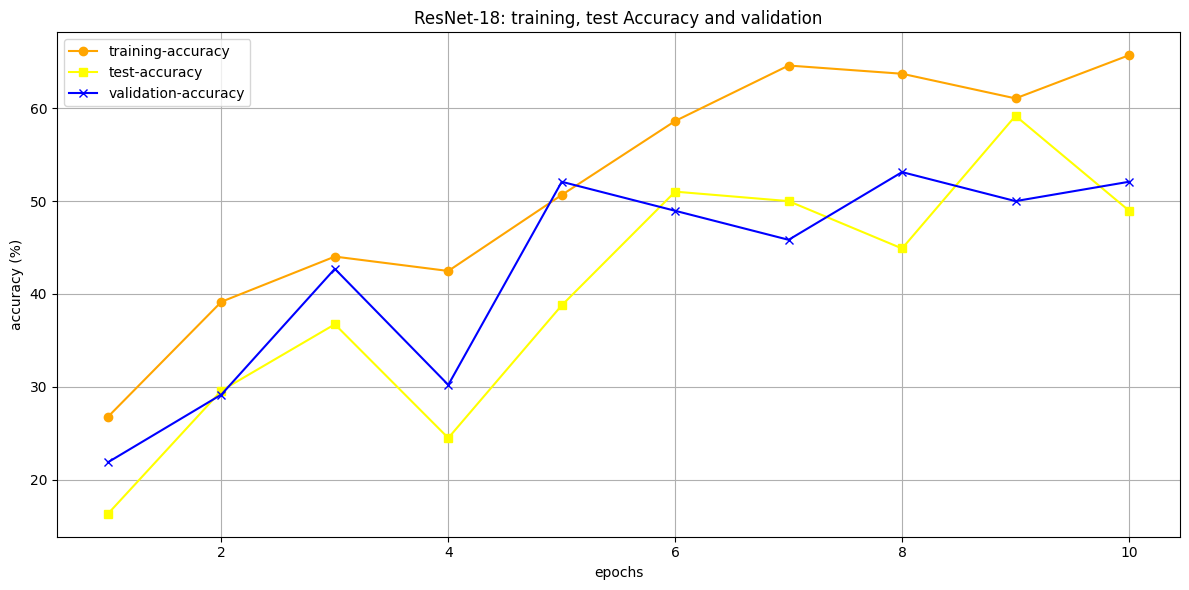

In [14]:
train_acc_rsnet, val_acc_rsnet, test_acc_rsnet = trainRsnet(rsNet_model, train_loader, val_loader, test_loader)
dbi_test_acc = test_acc_rsnet[-1]
print(f"DBI Test Accuracy: {dbi_test_acc:.2f}%")
epochs = range(1, 11)
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc_rsnet, label='training-accuracy', color='orange', marker='o')
plt.plot(epochs, test_acc_rsnet, label='test-accuracy', color='yellow', marker='s')
plt.plot(epochs, val_acc_rsnet, label='validation-accuracy', color='blue', marker='x')

plt.title('ResNet-18: training, test Accuracy and validation')
plt.xlabel('epochs')
plt.ylabel('accuracy (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:


#unzipping
!unzip -o "/content/drive/MyDrive/SSDsubset.zip" -d "/content/"
#remove unecessary files
!find /content/SSDsubset -name "__MACOSX" -exec rm -rf {} +
!find /content/SSDsubset -name "._*" -exec rm -rf {} +
!find /content/SSDsubset -name ".DS_Store" -exec rm -rf {} +
# SSD_path = '/content/SSDsubset'
# SDD_data = ImageFolder(root=SSD_path, transform=transform)
!ls /content/SSDsubset



Archive:  /content/drive/MyDrive/SSDsubset.zip
   creating: /content/SSDsubset/
  inflating: /content/__MACOSX/._SSDsubset  
   creating: /content/SSDsubset/n02099601-golden_retriever/
  inflating: /content/__MACOSX/SSDsubset/._n02099601-golden_retriever  
  inflating: /content/SSDsubset/.DS_Store  
  inflating: /content/__MACOSX/SSDsubset/._.DS_Store  
   creating: /content/SSDsubset/n02110185-Siberian_husky/
  inflating: /content/__MACOSX/SSDsubset/._n02110185-Siberian_husky  
   creating: /content/SSDsubset/n02085620-Chihuahua/
  inflating: /content/__MACOSX/SSDsubset/._n02085620-Chihuahua  
   creating: /content/SSDsubset/n02106166-Border_collie/
  inflating: /content/__MACOSX/SSDsubset/._n02106166-Border_collie  
   creating: /content/SSDsubset/n02107683-Bernese_mountain_dog/
  inflating: /content/__MACOSX/SSDsubset/._n02107683-Bernese_mountain_dog  
   creating: /content/SSDsubset/n02110958-pug/
  inflating: /content/__MACOSX/SSDsubset/._n02110958-pug  
   creating: /content/SSDs

In [16]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomCrop(112),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

path ='/content/SSDsubset'
data = ImageFolder(root=path, transform=transform)

print(f"Found {len(data)} images across {len(data.classes)} folder.")
#random check to see #folders
load_ssd = DataLoader(data, batch_size=32, shuffle=False)

count_folder = len(data.classes)
rsNet_model = resnet18(pretrained=False)#starting with no weights
# rsNet_model = resnet18(weights=None)


rsNet_model.fc = nn.Linear(rsNet_model.fc.in_features, count_folder)
#model to compute to cpu
rsNet_model = rsNet_model.to(device)



rsNet_model.eval()

def compare_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    validated = 0
    total = 0


    with torch.no_grad():
        for img, labels in dataloader:
            img, labels = img.to(device), labels.to(device)
            outputs = model(img)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            validated += (preds == labels).sum().item()

    #percentage
    accuracy = 100 * validated / total
    return accuracy

#running ResNEt model on SSD data to compare with Domain based image.
ssd_accuracy = compare_model(rsNet_model, load_ssd, device)
print(f"This data accuracy is : {ssd_accuracy:.2f}%")

Found 1233 images across 7 folder.
This data accuracy is : 17.60%
